__TODO : FIX BUG__
- [ ] Currently the code for constructing the synthetic spectra computes blocks of 1000 instead of 5000!


Recently I updated the GAMA-Legacy catalog to incorporate the latest Legacy DR7. A significant number of new galaxies are included in this catalog. Along with the GLeg catalog I've also updated the synethic spectra and re-ran them through redrock. In this notebook, I will examine and output the targets that `redrock` fails to recover correct redshift. 

Throughout the notebook I will consider redrock failures as objects with: 

($\frac{|z_\mathrm{redrock} - z_\mathrm{true}|}{(1.+z_\mathrm{true})} < 0.003$) and ZWARN = 0 

In [4]:
import h5py 
import numpy as np 
from astropy.io import fits
# -- feasibgs -- 
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [6]:
# read in GAMA-Legacy catalog
cata = Cat.GamaLegacy()
gleg = cata.Read('g15')

In [7]:
# select properties from the GAMA-Legacy catalog
redshift = gleg['gama-spec']['z']
# apparent magnitudes from Legacy photometry
g_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_g'])#, method='log')
r_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_r'])#, method='log')
# H-alpha line flux from GAMA spectroscopy
gama_ha = gleg['gama-spec']['ha_flux']

# absolute magnitude calculated using GAMA photometry
absmag_ugriz = cata.AbsMag(gleg, kcorr=0.1, H0=70, Om0=0.3)
g_absmag_gama = absmag_ugriz[1,:]
r_absmag_gama = absmag_ugriz[2,:]
ngal = len(redshift)
print('%i galaxies total' % ngal)

63495 galaxies total


In [37]:
def redrock_fail(iblock, nblock=13): 
    dir_spec = UT.dat_dir()+'spectra/gamadr3_legacydr7/'
    # read in gleg data
    fblock = h5py.File(dir_spec+'gleg.g15.darksky.seed1.exptime300.'+str(iblock)+'of'+str(nblock)+'blocks.hdf5', 'r')
    block = {}
    for g in fblock.keys():
        block[g] = {} 
        for k in fblock[g].keys(): 
            block[g][k] = fblock[g][k].value
    # read in redrock output 
    zblock = fits.open(dir_spec+'g15.synSpectra.darksky.seed1.exptime300.'+str(iblock)+'of'+str(nblock)+'blocks.redrock.fits')[1].data

    z_true = block['gama-spec']['z']
    z_rr = zblock['Z']
    dz_1pz = np.abs(z_true - z_rr)/(1.+z_true)

    zwarn = zblock['ZWARN']
    fail = (dz_1pz > 0.003) & (zwarn == 0)
    print('redrock fails for %i out of %i targets' % (np.sum(fail), len(z_rr)))

    # write out fail galaxies
    ffail = dir_spec+'gleg.g15.darksky.seed1.exptime300.'+str(iblock)+'of'+str(nblock)+'blocks.redrock_fail.hdf5'
    fail_block = {} 
    for g in block.keys(): 
        fail_block[g] = {}
        for k in block[g].keys():
            fail_block[g][k] = block[g][k][fail]
    cata.write(fail_block, ffail)
    return block, fail_block

In [38]:
block, fail_block = redrock_fail(1)

redrock fails for 35 out of 1000 targets


redrock fails for 35 out of 1000 targets
redrock fails for 22 out of 1000 targets
redrock fails for 16 out of 1000 targets
redrock fails for 26 out of 1000 targets
redrock fails for 18 out of 1000 targets
redrock fails for 26 out of 1000 targets
redrock fails for 24 out of 1000 targets
redrock fails for 22 out of 1000 targets
redrock fails for 26 out of 1000 targets


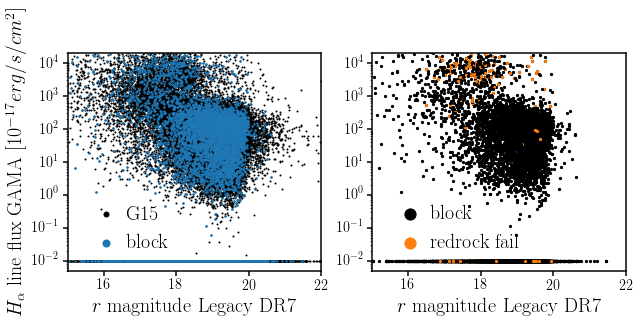

In [46]:
fig = plt.figure(figsize=(10, 4))
sub = fig.add_subplot(121)
sub2 = fig.add_subplot(122)
# entire G15 field
hasha = (gama_ha > 0)
sub.scatter(r_mag_legacy[hasha], gama_ha[hasha], s=1, c='k', label='G15')
sub.scatter(r_mag_legacy[~hasha], np.repeat(1e-2, np.sum(~hasha)), s=1, c='k')


for i in range(1,10):
    block, fail_block = redrock_fail(i)
    # block
    block_ha = block['gama-spec']['ha_flux']
    block_r_mag = UT.flux2mag(block['legacy-photo']['flux_r'])
    hasha = (block_ha > 0.)
    sub.scatter(block_r_mag[hasha], block_ha[hasha], s=2, c='C0', label='block')
    sub.scatter(block_r_mag[~hasha], np.repeat(1e-2, np.sum(~hasha)), s=2, c='C0')

    sub2.scatter(block_r_mag[hasha], block_ha[hasha], s=5, c='k', label='block')
    sub2.scatter(block_r_mag[~hasha], np.repeat(1e-2, np.sum(~hasha)), s=5, c='k')

    # redrock fails
    block_ha = fail_block['gama-spec']['ha_flux']
    block_r_mag = UT.flux2mag(fail_block['legacy-photo']['flux_r'])
    hasha = (block_ha > 0.)
    sub2.scatter(block_r_mag[hasha], block_ha[hasha], s=5, c='C1', label='redrock fail')
    sub2.scatter(block_r_mag[~hasha], np.repeat(1e-2, np.sum(~hasha)), s=5, c='C1')

    if i == 1: 
        sub.legend(loc='lower left', markerscale=5, handletextpad=0., fontsize=20)
        sub2.legend(loc='lower left', markerscale=5, handletextpad=0., fontsize=20)

sub.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=20)
sub.set_xlim([15., 22.])
sub.set_ylabel(r'$H_\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_ylim([5e-3, 2e4])
sub.set_yscale('log')

sub2.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=20)
sub2.set_xlim([15., 22.])
sub2.set_ylim([5e-3, 2e4])
sub2.set_yscale('log')

Figure above reveals that for a significant number of spectra with $r < 20$ and strong H$\alpha$ emission lines, redrock fails to recove the true redshift!